# Barotropic gyre

In [28]:
using Oceananigans
using Oceananigans.Units 
using Printf

Nx = 128
Ny = 128

Lx = 1200kilometers # east-west extent [m]
Ly = 1200kilometers # north-south extent [m]
Lz = 4kilometers    # depth [m]

# Set up the numerical grid
grid = RectilinearGrid(size = (Nx, Ny, 1),
                       x = (0, Lx),
                       y = (0, Ly),
                       z = (-Lz, 0),
                       topology = (Bounded, Bounded, Bounded))

# Parameters
β = 1.e-11
coriolis = BetaPlane(f₀=1e-4, β=β)

# Friction due to constant horizontal viscosity
@show νₕ = 2000 # m²/s
constant_horizontal_diffusivity = HorizontalScalarDiffusivity(ν = νₕ)

# Forcing by zonal wind stress
τ₀ = 0.1 # 0.1 N/m^3 is a realistic wind stress value
@show surface_wind_stress_parameters = (τ₀ = τ₀, ρ₀ = 1000., Lφ = grid.Ly)
@inline surface_wind_stress(x, y, t, p) = p.τ₀ / p.ρ₀ * cos(π * y / p.Lφ) # opposite sign convention as Vallis
surface_wind_stress_bc = FluxBoundaryCondition(surface_wind_stress,
                                               parameters = surface_wind_stress_parameters)
u_bcs = FieldBoundaryConditions(top = surface_wind_stress_bc)

@show model = HydrostaticFreeSurfaceModel(grid = grid,
                                    coriolis = coriolis,
                                    boundary_conditions = (u=u_bcs,),
                                    closure = constant_horizontal_diffusivity)

simulation = Simulation(model, Δt = 3600, stop_time = 10*365days)
output_fields = merge(model.velocities, (η=model.free_surface.η,))
output_prefix = "../data/raw_simulation_output/barotropic_gyre"

mutable struct Progress
    interval_start_time :: Float64
end

function (p::Progress)(sim)
    wall_time = (time_ns() - p.interval_start_time) * 1e-9

    @info @sprintf("Time: %s, iteration: %d, max(u): %.2e m s⁻¹, wall time: %s",
                   prettytime(sim.model.clock.time),
                   sim.model.clock.iteration,
                   maximum(sim.model.velocities.u),
                   prettytime(wall_time))

    p.interval_start_time = time_ns()

    return nothing
end

simulation.callbacks[:progress] = Callback(Progress(time_ns()), IterationInterval(10*24))


simulation.output_writers[:fields] = JLD2Writer(model, output_fields,
                                                schedule = TimeInterval(10days),
                                                filename = output_prefix,
                                                overwrite_existing = true)

@show run!(simulation)

νₕ = 2000 = 2000
surface_wind_stress_parameters = (τ₀ = τ₀, ρ₀ = 1000.0, Lφ = grid.Ly) = (τ₀ = 0.1, ρ₀ = 1000.0, Lφ = 1.2e6)
model = HydrostaticFreeSurfaceModel(grid = grid, coriolis = coriolis, boundary_conditions = (u = u_bcs,), closure = constant_horizontal_diffusivity) = HydrostaticFreeSurfaceModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 128×128×1 RectilinearGrid{Float64, Bounded, Bounded, Bounded} on CPU with 3×3×1 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: ()
├── closure: HorizontalScalarDiffusivity{ExplicitTimeDiscretization}(ν=2000.0)
├── buoyancy: Nothing
├── free surface: ImplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── solver: FFTImplicitFreeSurfaceSolver
├── advection scheme: 
│   └── momentum: Vector Invariant, Dimension-by-dimension reconstruction
└── coriolis: BetaPlane{Float64}


┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations /Users/henrifdrake/.julia/packages/Oceananigans/Rb6LJ/src/Simulations/run.jl:202
┌ Info: Time: 0 seconds, iteration: 0, max(u): 0.00e+00 m s⁻¹, wall time: 124.638 ms
└ @ Main /Users/henrifdrake/code/ESS130-public/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:51
┌ Info:     ... simulation initialization complete (98.236 ms)
└ @ Oceananigans.Simulations /Users/henrifdrake/.julia/packages/Oceananigans/Rb6LJ/src/Simulations/run.jl:245
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations /Users/henrifdrake/.julia/packages/Oceananigans/Rb6LJ/src/Simulations/run.jl:141
┌ Info:     ... initial time step complete (6.453 ms).
└ @ Oceananigans.Simulations /Users/henrifdrake/.julia/packages/Oceananigans/Rb6LJ/src/Simulations/run.jl:170
┌ Info: Time: 10 days, iteration: 240, max(u): 1.24e-02 m s⁻¹, wall time: 440.965 ms
└ @ Main /Users/henrifdrake/code/ESS130-public/notebooks/jl_notebook_cell

run!(simulation) = nothing


┌ Info: Simulation time 3650 days equals or exceeds stop time 3650 days.
└ @ Oceananigans.Simulations /Users/henrifdrake/.julia/packages/Oceananigans/Rb6LJ/src/Simulations/simulation.jl:212
┌ Info: Time: 3650 days, iteration: 87600, max(u): 2.65e-02 m s⁻¹, wall time: 434.057 ms
└ @ Main /Users/henrifdrake/code/ESS130-public/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:51


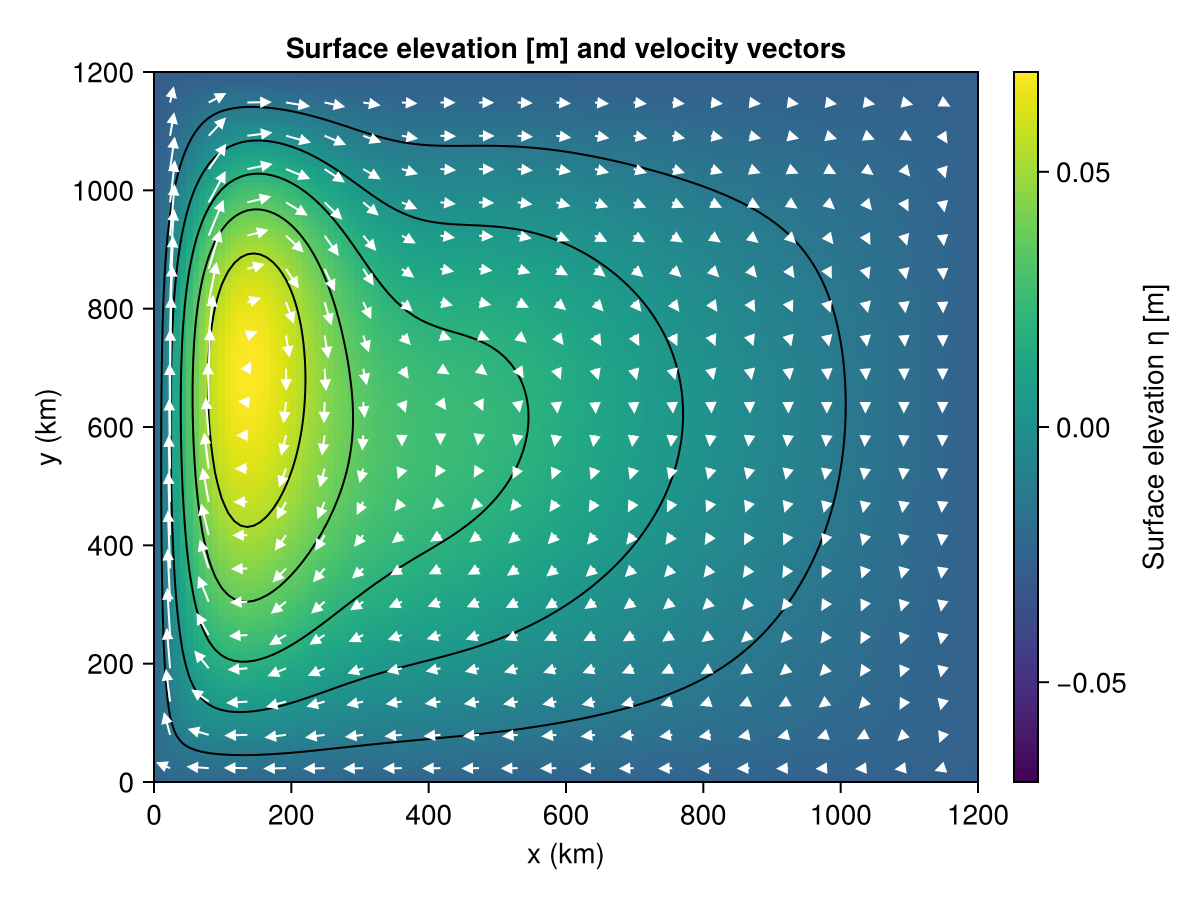

In [72]:
using CairoMakie

η = FieldTimeSeries(string(output_prefix,".jld2"), "η")
u = FieldTimeSeries(string(output_prefix,".jld2"), "u")
v = FieldTimeSeries(string(output_prefix,".jld2"), "v")

x, y, z = nodes(η)
η_data = interior(η)[:,:,1,end]
u_data = interior(u)[:,:,1,end]
v_data = interior(v)[:,:,1,end]
cmax = maximum(abs, η_data)

# Subsample for quiver (e.g., every 8th grid point)
stride = 6
xq = x[stride÷2:stride:end-1]
yq = y[stride÷2:stride:end-1]
uq = u_data[stride÷2:stride:end-1, stride÷2:stride:end]
vq = v_data[stride÷2:stride:end, stride÷2:stride:end-1]

Fig = Figure()
ax = Axis(
    Fig[1, 1],
    title = "Surface elevation [m] and velocity vectors",
    xlabel = "x (km)",
    ylabel = "y (km)"
)
hm = heatmap!(ax, x[:] ./ 1e3, y[:] ./ 1e3, η_data; colorrange = (-cmax, cmax), colormap=:viridis)
contour!(ax, x[:] ./ 1e3, y[:] ./ 1e3, η_data, color=:black)
quiver!(
    ax,
    xq[:] ./ 1e3, yq[:] ./ 1e3, 
    uq, vq, # transpose to match x/y orientation
    color=:white, 
    linewidth=1.0, 
    lengthscale=1000, # adjust as needed for clarity,
    arrowsize=8,
)
Colorbar(Fig[1, 2], hm, label = "Surface elevation η [m]")
Fig